**Table of contents**<a id='toc0_'></a>    
- 1. [代码库](#toc1_)    
- 2. [前言](#toc2_)    
- 3. [目标片段选择 + 扩增原理](#toc3_)    
- 4. [测序原理](#toc4_)    
- 5. [原始数据质控（QC）](#toc5_)    
- 6. [OTU聚类 vs. ASV推断：本质区别](#toc6_)    
  - 6.1. [合并双端](#toc6_1_)    
  - 6.2. [混合所有样本的reads](#toc6_2_)    
  - 6.3. [过滤和去冗余](#toc6_3_)    
  - 6.4. [去除嵌合体](#toc6_4_)    
  - 6.5. [OTU 聚类](#toc6_5_)    
  - 6.6. [ASV 降噪](#toc6_6_)    
  - 6.7. [OTU QC](#toc6_7_)    
    - 6.7.1. [ Align to a reference database](#toc6_7_1_)    
      - 6.7.1.1. [OTU 随机采样](#toc6_7_1_1_)    
      - 6.7.1.2. [ZOTU 随机采样](#toc6_7_1_2_)    
      - 6.7.1.3. [检查](#toc6_7_1_3_)    
    - 6.7.2. [All OTUs should appear in the OTU table](#toc6_7_2_)    
    - 6.7.3. [OTU coverage](#toc6_7_3_)    
    - 6.7.4. [Primer-binding sequences](#toc6_7_4_)    
  - 6.8. [构建特征表](#toc6_8_)    
  - 6.9. [抽样标准化](#toc6_9_)    
  - 6.10. [Diversity](#toc6_10_)    
    - 6.10.1. [alpha diversity](#toc6_10_1_)    
    - 6.10.2. [beta diversity](#toc6_10_2_)    
  - 6.11. [稀释曲线](#toc6_11_)    
    - 6.11.1. [Octave plots for visualizing alpha diversity](#toc6_11_1_)    
    - 6.11.2. [Alpha diversity rarefaction curve](#toc6_11_2_)    
  - 6.12. [物种注释](#toc6_12_)    
    - 6.12.1. [Algorithm](#toc6_12_1_)    
    - 6.12.2. [Rank annotation](#toc6_12_2_)    
- 7. [附录](#toc7_)    
  - 7.1. [格式化数据库](#toc7_1_)    
    - 7.1.1. [SINTAX downloads](#toc7_1_1_)    
    - 7.1.2. [makeudb_sintax](#toc7_1_2_)    
    - 7.1.3. [makeudb_usearch](#toc7_1_3_)    
    - 7.1.4. [makeudb_ublast](#toc7_1_4_)    
    - 7.1.5. [Check the information of dbs](#toc7_1_5_)    
    - 7.1.6. [udb2fasta](#toc7_1_6_)    
- 8. [Convert to html](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[代码库](#toc0_)

In [1]:
from deepspore.ipynb2py  import ipynb2

In [2]:
# Convert the Jupyter notebook labeled with "%%bash" to a bash script
ipynb2(ipynb_file= "./pipeline_v1.1.0_usearch.ipynb", label= "%%bash", output_file= "./scripts/pipeline.sh")

Saved 45 block(s) to ./scripts/pipeline.sh


In [3]:
import pandas as pd 
metainfo = pd.read_excel("datas/metadata.xlsx")

In [4]:
metainfo.head()

,SampleID,Group,Part,Breeding,Site,City,Soil,PreviousCrop,Altitude,Mode,...,Disease,早疫病,晚疫病,疮痂病,黑痣病,粉痂病,青枯病,黑胫病,枯萎病,病毒病
0,G1a,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
1,G1b,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
2,G1c,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
3,G1d,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0
4,G1e,G1,R,Lishu6,Yunnan,Lincang,SandySoil,Rice,1050,Single,...,早疫病,3,0,0,0,0,0,0,0,0


# 2. <a id='toc2_'></a>[前言](#toc0_)

The pipeline of aplicon analysis:

```python
样本 → DNA提取 → PCR扩增（16S/ITS）→ 测序 → 数据质控 → 去噪 → 特征表构建 → 分类注释 → 多样性分析 → 统计推断/可视化
```

usearch是一个非常有用的扩增子分析工具，软件本身使用仅有3.4M大小，但是功能非常多。

<div >
    <imga >
</div>

利用USEARCH获得特征表的路线图：

<div style="display:flex;justify-content:center">

```mermaid
---
title: USEARCH流程图
---
flowchart TD;
    A([raw reads])--"-fastq_mergepairs @"-->B[merged reads] --"-fastq_filter"--> C[filtered reads];
    C[filtered reads] --"-fastx_uniques"--> D[dereplicated reads];
    D --"-cluster_otus"--> OTU[OTU];
    D --"-unoise3"--> ZOTU[ZOTU];
    OTU --> fasta([reference sequences]);
    ZOTU --> fasta;
    fasta -. "-otutab/zotutab" .-> feature_table[OTU/ZOTU table];
    B -.-> feature_table;
    feature_table --"-otutab_rare"--> normalized([normalized table]);
    fasta --"-sintax"--> taxa[taxanomy];
```

</div>

# 3. <a id='toc3_'></a>[目标片段选择 + 扩增原理](#toc0_)

- 目标：用一段高变异但保守两端的基因区域（如16S V3-V4）来代表一个微生物“种”的指纹。

- 原理：
  - 16S rRNA 是细菌保守基因，V区（可变）能分辨不同种；
  - PCR 用通用引物扩增这些区段；
  - 条形码（barcode）用于样本区分，接头用于测序平台识别。

✅ 总结：PCR 在 amplicon 中的角色

| 内容           | 描述              |
| ------------ | --------------- |
| 🔧 **必须步骤？** | 是的，为富集目标区片段用于测序 |
| 🧪 **最大好处？** | 低成本、特异富集、高通量处理  |
| ⚠️ **主要缺点？** | 引物偏倚、嵌合体、失真丰度   |

🧬 替代方法对比（不使用 PCR）：

| 方法                   | 是否 PCR | 特点             | 成本       |
| -------------------- | ------ | -------------- | -------- |
| Amplicon（如 16S）      | ✅ 有    | 成本低、靶向高        | 💰 低     |
| Shotgun Metagenomics | ❌ 无    | 全基因组测序，包含所有微生物 | 💰💰💰 高 |
| Metatranscriptomics  | ❌ 无    | 表达层面测序（mRNA）   | 💰💰 高   |

✅ 常见扩增区域（以 16S rRNA 为例）

| 扩增区域  | 常用引物       | 长度（bp） | 特点                | 分辨率 | 缺点                        |
| ----- | ---------- | ------ | ----------------- | --- | ------------------------- |
| V1–V2 | 27F/338R   | \~300  | 适用于口腔、皮肤等         | 高   | 偏倚严重                      |
| V3–V4 | 341F/806R  | \~460  | 常用于肠道、土壤等，文献最多    | 中等  | 一定偏倚                      |
| V4    | 515F/806R  | \~250  | 通用性强，Illumina 最兼容 | 中等  | 分辨率略低                     |
| V4–V5 | 515F/926R  | \~400  | 更好区分部分属           | 中   | 偏倚存在                      |
| V5–V7 | 785F/1175R | \~390  | 动物/人体样本常用         | 较高  | 偏倚较高                      |
| 全长16S | 27F/1492R  | \~1500 | 三代测序使用，最高分辨率      | 高   | 成本高，仅限三代测序平台（如PacBio/ONT） |

🧬 如何选择扩增区域？

| 样本来源     | 推荐区域          | 理由             |
| -------- | ------------- | -------------- |
| 肠道（人或动物） | V3–V4 / V4    | 数据多，分辨率和通用性均衡  |
| 土壤、水环境   | V4 / V4–V5    | 通用性强，适合复杂微生物群落 |
| 皮肤、口腔    | V1–V2 / V3–V4 | 能更好捕获部分常见菌属    |
| 极端环境     | 全长16S         | 更好物种判定（如新种）    |
| 共生菌、低丰度菌 | 全长16S         | 需高分辨率定位分类位次    |


# 4. <a id='toc4_'></a>[测序原理](#toc0_)

- 平台如 Illumina：
  - 每条读长通常为 250–300 bp，双端（forward & reverse）；
  - 实际构成的序列需拼接（paired-end merging）。

In [1]:
%%bash 
# ls ../china_16s/datas/raw/ | wc -l
# ls ../china_16s/datas/raw/ | head -n 5

echo "The total number of files:"
ls ./datas/raw/ | wc -l
ls ./datas/raw/ | head -n 5

The total number of files:
7334
F146a_1.fastq
F146a_2.fastq
F146b_1.fastq
F146b_2.fastq
F146c_1.fastq


# 5. <a id='toc5_'></a>[原始数据质控（QC）](#toc0_)

- 目的：去除低质量和无用序列，确保后续分析可靠。
  - 去接头/引物：使用工具如 cutadapt；
  - 去低质量序列：依据Phred值（错误概率）进行裁剪或过滤；
  - 合并双端（如 vsearch --fastq_mergepairs）；
  - 去除嵌合体：嵌合体是PCR中产生的假序列（如DADA2的removeBimeraDenovo）；
  - 去噪（denoising）：提取真实的ASV序列（见下一节）；

In [ ]:
%%bash 
# store the QC results
mkdir -p ./results/qc
ls -h ./results/qc

# 6. <a id='toc6_'></a>[OTU聚类 vs. ASV推断：本质区别](#toc0_)

什么是OTUs？ [https://drive5.com/usearch/manual/otus.html](https://drive5.com/usearch/manual/otus.html)

OTU概念：
- Sneath-Sokal OTUs: OTU（操作分类单元）的概念由Peter Sneath和Robert Sokal于1960年代提出，奠定了数值分类学的基础（参见《数值分类学》，Sneath & Sokal, 1973）。其目标是通过可量化的性状（如1=存在，0=缺失）对生物进行分组，构建反映进化关系的层级分类体系。Sneath-Sokal OTU通过聚合聚类算法将相似性状的生物合并，这是生物分类中早期聚类应用的范例。当时尚无DNA测序技术，也未发展出邻接法或最大似然法等系统发育树构建方法。
- 97%相似度阈值的起源：16S测序中，OTU通常以97%相似度为阈值。据考证，该阈值首次由Stackebrandt和Goebel（1994）提出，他们发现16S序列97%的相似度对应70%的DNA重关联值，而后者当时被用作细菌物种的界定标准（Wayne等，1987）。
- 现代OTU相似度阈值：2014年分析：使用CD-HIT聚类全长16S序列时，最佳阈值为98.5%（Yarza等，2014），但CD-HIT的相似度定义存在争议（Edgar，2018a）。近期研究：全长序列最佳阈值为99%，V4区为100%（Edgar，2018b）。

16S序列聚类的发展：
- FastGroup（2001）：首个16S聚类工具，采用类似UCLUST的贪婪算法，默认97%阈值（引用Stackebrandt & Goebel）。
- DOTUR/mothur（2005/2009）：支持最大/最小/平均连接聚类，提出“97%相似度≈物种，95%≈属，80%≈门”（但存在争议）。
- QIIME（2010）：长期沿用97%阈值，早期依赖CD-HIT，后改用UCLUST，但未明确说明OTU的生物学解释。

OTU的定义：
- OTU作为物种的临时定义：在1990年代，通过PCR和Sanger测序获取的16S序列较少，数据库比对受限。此时，97%聚类的OTU可作为临时物种单元，前提是忽略实验误差（当时普遍未考虑PCR嵌合体等问题）。
- 高通量测序时代的OTU：NGS的短读长和高错误率导致传统聚类产生大量虚假OTU，夸大多样性估计（如Huse等，2010）。截至2017年，QIIME等工具在模拟群落（含20物种）中仍报告成百上千的OTU，凸显误差问题。
- Westcott与Schloss的OTU定义：二人提出基于马修斯相关系数（MCC）的OTU定义，但实际应用存在缺陷。



| 方法 | OTU (Operational Taxonomic Units) | ASV (Amplicon Sequence Variants) |
|------|----------------------------------|----------------------------------|
| **原理** | 基于相似度聚类（如97%） | 基于统计误差模型去噪，识别每一个真实变异 |
| **工具** | USEARCH, VSEARCH | DADA2, Deblur |
| **缺点** | 分辨率低，可能混淆近缘种 | 精度高，但计算要求高 |
| **本质** | 聚类简化 | 精确建模变异与测序误差 |

🔍 推荐：ASV 现为主流做法，适用于精细多样性分析。

OTU的解释性：
- 目标模糊：许多研究未明确说明OTU的构建目标或验证方法。
- 模拟群落的局限性：
  - 参数过拟合：在测试数据上调参可能导致虚假“准确性”。
  - 错误归因：OTU数量正确可能因“错误抵消”（如嵌合体与物种混叠）。
- 统计误导：未校正的误差可能导致假显著性（Taylor，1997）。

USEARCH中的OTU定义：
- UPARSE-OTU（cluster_otus命令）：报告正确生物序列的子集，满足（a）OTU间相似度<97%，（b）OTU序列为局部最丰富。
- **ZOTUs（unoise3命令）：**
  - 目标：报告所有真实生物序列（零半径OTU），可区分近缘菌株（97% OTU会合并）。
  - 优势：保留菌株水平变异（如旁系同源或菌株差异）。

USEARCH中的OTU丰度的计算：
- ZOTUs：计数源自同一模板序列的所有读长（含错误读长）
- 97% OTUs：计数与OTU序列≥97%相似的所有生物序列读长。若读长匹配多个OTU，按最高相似度分配（相同则按文件顺序）。
- 关键问题：读长丰度与物种真实丰度相关性极低，生物学解释需谨慎。

总结
- OTU的本质取决于算法目标：
  - UPARSE-OTU：保守近似物种，牺牲分辨率换取稳定性。
  - ZOTUs：追求真实序列，揭示菌株级变异但需处理更高复杂度。
- **生物学推论必须结合方法局限性，避免过度解读统计显著性。**

## 6.1. <a id='toc6_1_'></a>[合并双端](#toc0_)

- 合并双端reads是将两个方向的测序数据拼接成一个完整的序列。
- 去除引物
- 质量控制
- 等等

```bash
# demo:
usearch -fastq_mergepairs Mock_R1.fq -fastqout merged.fq -relabel @ # @ 用当前文件名作为序列名，并以"."加数字形式命名序列
usearch 
```

In [18]:
%%bash 
# store the merge read results 
mkdir -p ./results/merge_read

In [ ]:
#@save_merge_reads
from deepspore import run_cmd, num_thread, parallel 
import os 


def task(file_name:str) -> None:
    '''Qualitify Merged reads, such as merge reads, trimi primer, and etc.'''
    # Merge the read files
    file_1, file_2 = tuple(f"./datas/raw/{file_name}_{i}.fastq" for i in [1, 2])
    merge_file = f"./results/merge_read/{file_name}.fastq"
    ## @ 很重要
    merge_reads = f"usearch11 -fastq_mergepairs {file_1} -reverse {file_2} -fastqout {merge_file} -relabel @"

    # Remove the primers
    # f"usearch11 -fastx_trim_primer {merge_file} -db primers.fa -strand both -maxdiffs 1 -width 0 -fastqout ./results/merge_read/{file_name}_trim.fastq"
    
    # run cmd via subprocess module
    run_cmd(merge_reads)
    

if __name__ == "__main__":
    print("Starting the merging process...")
    # Get all file_name to a tuple.
    file_name_list = {file.split("_")[0] for file in os.listdir("./datas/raw")}
    # Build the tasks consist of tuple which contains function and its paramters.
    tasks = [(task, (file_name,)) for file_name in file_name_list]
    # Directly using Pool, with stop manually.
    parallel(tasks= tasks, num_threads= num_thread())
    print("All finished.")

In [54]:
# Send to a one py file, and lanuch with Python command.
# python ./scripts/merge_reads.py
ipynb2(ipynb_file= "./pipeline_v1.1.0_usearch.ipynb", label= "#@save_merge_reads", output_file= "./scripts/merge_reads.py")

Saved 1 block(s) to ./scripts/merge_reads.py


In [23]:
%%bash 
echo Total numbers:
ls ./results/merge_read | wc -l

echo Such as :
ls ./results/merge_read | head -n 6

Total numbers:
3667
Such as :
F146a.fastq
F146b.fastq
F146c.fastq
F146d.fastq
F146e.fastq
F147a.fastq


## 6.2. <a id='toc6_2_'></a>[混合所有样本的reads](#toc0_)

[https://drive5.com/usearch/manual/pool_samples.html](https://drive5.com/usearch/manual/pool_samples.html)

合并所有过滤过的序列为到一个fastq文件中，让所有样品在一个标准环境下处理，才能进行比较分析。

In [ ]:
%%bash 
mkdir -p ./results/merge_read_all_samples/

# merge all the samples
echo "Merging all the samples into one file ..."
cat ./results/merge_read/* > ./results/merge_read_all_samples/all_samples.fastq
echo "Finished."

echo "Total sequences in merge fastq files:"
grep "@"  results/merge_read_all_samples/all_samples.fastq | wc -l
# 137888093

Merging all the samples into one file ...
Finished.


## 6.3. <a id='toc6_3_'></a>[过滤和去冗余](#toc0_)

在聚类或降噪之前进行：
- 过滤低丰度：
  - 在所有样品这一标准下确定哪些是低丰度的序列是更加科学的；

In [ ]:
%%bash
echo "Discard reads which probably have errors (quality filtering) ..."
usearch11 \
    -fastq_filter ./results/merge_read_all_samples/all_samples.fastq \
    -fastq_maxee 1.0 \
    -relabel Filt \
    -threads 62 \
    -fastaout ./results/merge_read_all_samples/all_samples_filtered.fasta

remove the low abun. sequence ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:00 4.8Mb  FASTQ base 33 for file ./results/merge_read_all_samples/all_samples.fastq
26:01 4.6Gb   100.0% Filtering, 88.4% passed0:09 4.6Gb     0.6% Filtering, 86.4% passed1:45 4.6Gb     6.9% Filtering, 85.3% passed:05 4.6Gb     8.2% Filtering, 85.2% passed2:59 4.6Gb    11.6% Filtering, 86.3% passed3:13 4.6Gb    12.5% Filtering, 86.5% passed4:12 4.6Gb    16.2% Filtering, 87.1% passed4:18 4.6Gb    16.6% Filtering, 87.2% passed4:45 4.6Gb    18.3% Filtering, 87.4% passed5:22 4.6Gb    20.7% Filtering, 87.7% passed6:09 4.6Gb    23.6% Filtering, 87.8% passed    28.9% Filtering, 88.2% passed7:52 4.6Gb    30.1% Filtering, 88.3% passed7:58 4.6Gb    30.5% Filtering, 88.3% passed8:26 4.6Gb    32.3% Filtering, 88.4% passed8:52 4.6Gb    33.9% Filtering, 88.5% passed 4.6Gb    34.3% Filtering, 88.5% passed, 88.6% passed0:10 4.6Gb    38.8% Filtering, 88.7% passed1:02 4.6Gb    42.1% Filtering, 88.9% passed1:40 4.6Gb    44.5% Filtering, 88.9% passed2:20 4.6Gb    47.0% Filtering, 88.9% passed2:21 4.6Gb

In [3]:
%%bash
echo "Filtered nums:"
grep ">" results/merge_read_all_samples/all_samples_filtered.fasta  | wc -l
# 121830004

Filtered nums:
121830004


In [1]:
(137888093 - 121830004)/137888093

0.11645740143784569

在聚类或降噪之前进行：
- 去冗余：
  - 减少序列数目，减少后续聚类数据量，加快速度；

In [103]:
%%bash 
echo "dereplicate ..."
usearch11 \
        -fastx_uniques ./results/merge_read_all_samples/all_samples_filtered.fasta \
        -relabel Uniq \
        -sizeout \
        -fastaout ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fasta \
        -threads 62

dereplicate ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



11:18 53.5Gb  100.0% Reading ./results/merge_read_all_samples/all_samples_filtered.fastataasta.fastastaed.fastatafastatailtered.fastaltered.fastaastaered.fastafastaastales_filtered.fastaed.fastatastastaafastastataasta.fastaa.fastaastafastasamples_filtered.fastas_filtered.fastaamples_filtered.fastad_all_samples/all_samples_filtered.fastafastamples/all_samples_filtered.fastaples_filtered.fastaalts/merge_read_all_samples/all_samples_filtered.fastatasamples_filtered.fastafastaed.fastamples_filtered.fastaaered.fastaes_filtered.fastatata.fastatered.fasta_read_all_samples/all_samples_filtered.fastatared.fastared.fastad.fastaered.fastaes_filtered.fastastaered.fastaples_filtered.fastaed.fastaltered.fastataastata_samples/all_samples_filtered.fastad.fastaered.fastaastaltered.fastatered.fastaples/all_samples_filtered.fasta
12:57 187Gb   100.0% DF                                                                 
13:16 189Gb  121830004 seqs, 52894077 uniques, 43808893 singletons (82.8%)
13:16 189Gb  

In [4]:
%%bash
echo "Dereplicate nums:"
grep ">" results/merge_read_all_samples/all_samples_filtered_dereplicated.fasta  | wc -l
# 52894077

Dereplicate nums:
52894077


In [10]:
print(f"deplicate {(121830004-52894077)/ 121830004 * 100:.2f}% reads.")

deplicate 56.58% reads.


In [ ]:
# %%bash 
# cat merge_read_all_samples/all_samples_filtered_dereplicated.fasta | grep ">" > uniq_size.txt

关于是否去除singleton的讨论：[https://drive5.com/usearch/manual/singletons.html](https://drive5.com/usearch/manual/singletons.html)

- 去除singleton unique sequences:
  - singleton表示只是出现一次的序列；
  - 很多singleton是应为交叉污染造成的（如取样，测序过程等等）。
  - 去冗余后，每个序列的 size 值表示其原始出现次数。
  - 按照文件中size数目降序排列，仅保留 size≥2 的序列，自动去除 Singletons。

- 影响：
  - 正向作用：Singleton 中可能包含大量由PCR扩增错误或测序仪产生的随机噪声（如碱基错配）。去除后能显著减少假阳性OTU，提高后续聚类（如97%相似度OTU）的准确性；
    - 由于singleton较多，取出后可加速后期聚类速度。
  - 风险：可能误删真实存在的稀有物种（如低丰度但功能关键的微生物），尤其在深测序样本中。
    - 降低丰富度（Richness）：直接减少OTU数量，尤其对稀疏样本（如低生物量环境）影响更大。
    - 缓解“测序深度偏差”：避免因个别样本测序深度过高而引入虚假稀有物种，使多样性指标（如Shannon指数）更稳定
    - 提高BETA结果一致性：去除噪音后，样本间差异更反映真实生物学变异（如环境梯度或疾病状态）
    - 潜在失真：若研究关注稀有微生物的分布模式（如环境监测中的指示物种），可能丢失关键生态信号

In [ ]:
%%bash
echo "discard singleton unique sequences ..."
# 按照文件中size数目降序排列，仅保留 size≥2 的序列，自动去除 Singletons。
usearch11 \
    -sortbysize ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fasta \
    -fastaout ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta \
    -minsize 2 \
    -threads 62

In [11]:
%%bash 
echo `cat ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta | grep ">" | wc -l`
# 9085184

9085184


In [16]:
print(f"去除了{(52894077 - 9085184)*100/52894077:.2f}%个singleton序列.")

去除了82.82%个singleton序列.


In [5]:
%%bash 
usearch11 \
    -sortbysize ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fasta \
    -minsize 8 \
    -fastaout ./results/merge_read_all_samples/all_samples_filtered_dereplicated8.fasta \
    -threads 62

usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



04:59 23.2Gb  100.0% Reading ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaafiltered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa1:11 6.2Gb    26.7% Reading ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaales/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa2:25 12.0Gb   51.6% Reading ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaes_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa3:42 17.8Gb   76.5% Reading ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaa4:02 19.1Gb   82.3% Reading ./results/merge_read_all_samples/all_samples_filtered_dereplicated.fastaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
04:59 23.2Gb Getting sizes                                                                           
05:

In [8]:
%%bash 
cat ./results/merge_read_all_samples/all_samples_filtered_dereplicated8.fasta | grep ">" | wc -l

845440


In [9]:
9085184 - 845440

8239744

## 6.4. <a id='toc6_4_'></a>[去除嵌合体](#toc0_)

- 在USEAECH中此步可选

In [ ]:
# %%bash 
# # spend many time.
# usearch11 \
#     -uchime3_denovo ./results/merge_read_all_samples/all_samples_dereplicated.fasta \
#     -nonchimeras ./results/merge_read_all_samples/all_samples_dereplicated_nonchimeras.fasta \

## 6.5. <a id='toc6_5_'></a>[OTU 聚类](#toc0_)

UPARSE是USEARCH/VSEARCH中用于生成 OTUs（Operational Taxonomic Units）的高效聚类算法，通过严格的去噪和聚类策略，在保证生物学意义的前提下减少假阳性。其核心特点是 基于97%相似度阈值的聚类，但通过预处理步骤显著优于传统聚类方法（如CD-HIT）。

- 核心步骤：

| 步骤          | 操作                                  | 目的 |
|---------------|---------------------------------------|----------------------------------------------------------------------|
| 输入质控      | 过滤低质量序列（如 `maxee≤1.0`，长度截断） | 去除测序错误和引物/接头污染，提高数据可靠性  |
| 去重与排序    | 合并完全相同的序列（去重），按丰度降序排序   | 减少计算量，优先处理高可信序列（高频序列更可能代表真实生物信号）  |
| 去噪（可选）  | 移除低丰度序列（如 `minsize=8`）          | 过滤可能的测序错误（类似 UNOISE3 的预去噪策略）  |
| 贪婪聚类      | 从最高丰度序列开始，作为 OTU 中心，吸收相似度≥97%的序列 | 生成生物学有意义的 OTUs，确保同一 OTU 内序列高度同源  |
| 嵌合体检测    | 使用 `uchime_ref` 或 `uchime_denovo` 移除嵌合体 | 避免跨物种序列拼接导致的假 OTU，提升代表序列的准确性  |

- 核心算法：
  - 丰度过滤：低丰度序列（如<8 copies）被直接过滤，保留条件：序列丰度≥minsize；
  - 序列相似度计算：采用全局比对（如Needleman-Wunsch算法）计算序列相似度。相似度$=1-\frac{\text{错配数量}+\text{空位罚分}}{\text{对齐长度}}$

  - 什么是贪心算法？
    - 优先级：从最高丰度序列开始，作为OTU中心。
    - 吸收规则：若序列与OTU中心的相似度≥阈值（默认97%），则归入该OTU，且不再参与后续聚类。
    - 终止条件：所有序列处理完毕或达到预设OTU数量。

- 基本演示
```python
# 使用UPARSE生成OTUs
usearch -fastq_filter raw.fq -fastq_maxee 1.0 -fastaout filtered.fa
usearch -fastx_uniques filtered.fa -sizeout -relabel Uniq -fastaout uniques.fa
usearch -cluster_otus uniques.fa -minsize 8 -otus otus.fa -relabel OTU

# 参数说明：
# -fastq_maxee 1.0：过滤预期错误>1.0的序列
# -minsize 8：忽略丰度<8的序列
# -relabel Otu：重命名OTU编号
```

In [ ]:
%%bash 
echo "otu cluser ..."
# spend long time.
nohup usearch11 \
    -cluster_otus ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta \
    -otus ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
    -relabel Otu \
    -threads 62 > caches/cluster2otu.log 2>&1 &

如果usearch聚类速度太慢可以用vsearch算法进行聚类：

In [ ]:
# %%bash 
# echo "otu cluser via vsearch ..."
# vsearch \
#     --cluster_size ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta \
#     --id 0.97 \
#     --centroids ./caches/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
#     --relabel Otu \
#     --threads 62
# 1099001 OTUs

In [2]:
%%bash 
echo `cat results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta | grep ">" | wc -l`
echo `cat results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu12.fasta | grep ">" | wc -l`
# head -n 10 results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu12.fasta

158639


157305


## 6.6. <a id='toc6_6_'></a>[ASV 降噪](#toc0_)

UNOISE3是一种基于丰度排序和误差校正的高精度序列去噪算法，用于直接从扩增子测序数据中生成零半径OTUs（Zero-radius, ZOTUs），分辨率达到单碱基差异水平（株水平）。其核心创新在于完全摒弃传统聚类阈值，转而通过统计模型识别并移除测序错误。

- 核心步骤：

| 步骤          | 操作                                  | 数学基础                                                                 | 生物学意义                                                                 |
|---------------|---------------------------------------|--------------------------------------------------------------------------|----------------------------------------------------------------------------|
| 序列质控      | 过滤低质量序列（如 Phred<30）          | **质量评分模型**：$Q = -10\log_{10}(P_{\text{error}})$                    | 去除不可靠碱基，确保后续分析的序列可靠性                                     |
| 丰度排序      | 按序列丰度降序排列                     | **泊松分布假设**：$P(\text{noise}) = \frac{\lambda^k e^{-\lambda}}{k!}$ | 高丰度序列更可能是真实生物信号（低频序列更可能为噪声）                       |
| 错误校正      | 将低丰度序列归为高丰度序列的误差变体   | **贪婪算法**：若 $d(H_i, L_j) \leq \varepsilon$，则 $L_j$ 标记为错误     | 消除 PCR 扩增错误和测序仪引入的碱基错误                                      |
| ZOTU生成      | 保留未被标记为错误的唯一序列           | **集合论**：$\text{ZOTU} = \{ S \mid S \notin \text{Error\_set} \}$      | 获得真实生物变异（ZOTU 代表 100% 相同的生物序列，分辨率达菌株水平）           |


- 优势对比：

| 工具        | 输出类型 | 分辨率   | 运行速度 | 假阳性控制 |
|-------------|----------|----------|----------|-------------|
| UNOISE3     | ZOTUs    | 株水平   | 极快     | 严格        |
| DADA2       | ASVs     | 种水平   | 中等     | 中等        |
| Deblur      | ASVs     | 种水平   | 慢       | 严格        |
| 97% OTU聚类 | OTUs     | 属水平   | 快       | 宽松        |

- 基本演示：

```python
usearch -unoise3 input.fasta -zotus zotus.fasta

# 关键参数解释：
# -minsize 8：设置最小序列丰度阈值（默认8）；
```


In [ ]:
%%bash 
echo "zotu ..."
# spend long time.
nohup usearch11 \
    -unoise3 ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta \
    -zotus ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
    -threads 62 > caches/denoise2zotu.log 2>&1 &

如果usearch的降噪速度太慢，可用vsearch替代：
- The numbers of cluster ZOTUs more about 100000 than usearch cluster ZOTUs.

In [ ]:
# %%bash
# echo "unoise via vsearch ..."
# vsearch  \
#     --cluster_unoise ./results/merge_read_all_samples/all_samples_filtered_dereplicated2.fasta \
#     --centroids ./caches/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
#     --minsize 8 \
#     --relabel Zotu \
#     --threads 62
# 253705 ZOTUs

In [19]:
%%bash
echo "zotu nums:"
grep ">" results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta | wc -l
# 165993

grep ">" results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu12.fasta | wc -l
# 167170

zotu nums:
165993
167170


In [4]:
print(f"{165993*100/9085184:.2f}%个zotu序列.")

1.83%个zotu序列.


## 6.7. <a id='toc6_7_'></a>[OTU QC](#toc0_)

[https://drive5.com/usearch/manual/otu_qc.html](https://drive5.com/usearch/manual/otu_qc.html)


| 问题类型         | 描述                                                                 |
|------------------|----------------------------------------------------------------------|
| 比对异常         | OTU序列是否与目标基因的参考数据库良好比对？                          |
| OTU缺失          | 所有OTU是否均出现在OTU表中？                                         |
| 覆盖率不足       | OTU能解释多大比例的数据？                                            |
| 短片段构建       | PCR产生的异常测序结构                                                |
| 链重复           | 同时存在正链和负链序列                                                |
| 位置偏移         | 序列在基因中的起始位置不一致                                          |
| 样本间交叉污染   | 读长被错误分配至其他样本                                              |
| 测序错误         | 聚合酶错误或碱基识别错误                                              |
| 低复杂度序列     | 测序仪噪声（如多聚核苷酸重复）                                        |
| PhiX污染         | 未过滤的标钉（spike-in）控制序列                                      |
| 嵌合体           | 未过滤的PCR嵌合体                                                    |
| 非目标扩增       | 引物扩增了非目标区域                                                  |
| 外源污染         | 显而易见的污染序列（如人源、环境DNA）                                |
| 引物残留         | 引物结合序列应在分析流程起始阶段去除                                  |
| 过度紧密OTU      | 相似度>97%的OTU（可能需进一步拆分）                                  |


In [21]:
%%bash 
mkdir -p ./results/otu_qc

### 6.7.1. <a id='toc6_7_1_'></a>[ Align to a reference database](#toc0_)

[https://drive5.com/usearch/manual/otu_qc_align.html](https://drive5.com/usearch/manual/otu_qc_align.html)

I strongly recommend aligning your OTUs to a large reference database and reviewing some selected alignments. For most samples, use the largest available reference database for your gene. e.g. SILVA for 16S or UNITE for ITS. If you have control samples (mock community or single strain), then you should align the control OTU sequences to the known sequences in the strain(s).

**Check highest and lowest abundance, shortest and longest sequence**

You can select a random subset to review by using the **fastx_subsample** command. I recommend reviewing the top few most abundant OTUs, and also a few of the least abundant. These alignments are especially likely to reveal problems. Also check the shortest and longest sequences.

#### 6.7.1.1. <a id='toc6_7_1_1_'></a>[OTU 随机采样](#toc0_)

In [1]:
%%bash
echo "Subsamples with 10% ..."
usearch11 \
    -fastx_subsample results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
    -sizein \
    -sizeout \
    -sample_pct 10 \
    -randseed 1 \
    -fastaout results/otu_qc/all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta

Subsamples with 10% ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:00 39Mb    100.0% Counting seqs
00:00 40Mb    100.0% Sampling     


In [2]:
%%bash 
echo "Checking the subsamples with Database sequence ..."
usearch11 \
    -usearch_global results/otu_qc/all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta \
    -db dbs/silva_16s_v123_usearch.udb \
    -id 0.9 \
    -strand both \
    -alnout ./results/otu_qc/otu_10.aln \
    -uc ./results/otu_qc/otu_10.uc \
    -threads 60

Checking the subsamples with Database sequence ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:05 8.5Gb   100.0% Rows
00:05 8.6Gb  Reading pointers...done.
00:05 8.8Gb  Reading db seqs...done.
02:07 17.3Gb  100.0% Searching all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta, 65.8% mathedtchedched chedchedchedched0:13 17.3Gb    5.5% Searching all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta, 93.8% matchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedched0:46 17.3Gb   34.1% Searching all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta, 80.1% matchedchedchedchedchedchedchedchedchedchedchedched0:58 17.3Gb   43.6% Searching all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta, 76.7% matchedchedchedchedchedchedched1:05 17.3Gb   49.5% Searching all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta, 74.8% matchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedchedched1:32 17.3Gb   71.5% Searching all_samples_filtered_derepli

#### 6.7.1.2. <a id='toc6_7_1_2_'></a>[ZOTU 随机采样](#toc0_)

In [22]:
%%bash
echo "Subsamples with 10% ..."
usearch11 \
    -fastx_subsample results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
    -sizein \
    -sizeout \
    -sample_pct 10 \
    -randseed 1 \
    -fastaout results/otu_qc/all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta

Subsamples with 10% ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:00 39Mb    100.0% Counting seqs
00:01 40Mb    100.0% Sampling     


In [1]:
%%bash 
echo "Checking the subsamples with Database sequence ..."
usearch11 \
    -usearch_global results/otu_qc/all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta \
    -db dbs/silva_16s_v123_usearch.udb \
    -id 0.9 \
    -strand both \
    -alnout ./results/otu_qc/zotu_10.aln \
    -uc ./results/otu_qc/zotu_10.uc \
    -threads 60

Checking the subsamples with Database sequence ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:07 8.5Gb   100.0% Rows
00:07 8.6Gb  Reading pointers...done.
00:08 8.8Gb  Reading db seqs...done.
07:08 17.3Gb  100.0% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 95.4% mached0:13 17.3Gb    0.6% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 100.0% matchedatched0:25 17.3Gb    1.3% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 100.0% matchedatchedatchedatched0:44 17.3Gb    2.9% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 100.0% matchedtched tchedtchedtched1:02 17.3Gb    4.4% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 99.7% matchedtchedtchedtchedtchedtched1:18 17.3Gb    6.5% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 99.6% matched1:22 17.3Gb    7.7% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 99.4% matched1:25 17.3Gb    8.6% Searching all_samples_filtered_dereplicated_nonchimeras_zotu_10.fasta, 99.3% m

#### 6.7.1.3. <a id='toc6_7_1_3_'></a>[检查](#toc0_)

Review the alignments in the otu.aln file. Look for patterns which might not be biological. For example, if you see that many OTUs have mismatches near the beginning or end of the sequence, this may be due to primer-binding sequences which should be stripped because PCR tends to cause substitutions.

In [3]:
%%bash 
cat ./results/otu_qc/otu_10.aln | head -n 50
# cat ./results/otu_qc/zotu_10.aln | head -n 50

usearch11 -usearch_global results/otu_qc/all_samples_filtered_dereplicated_nonchimeras_otu_10.fasta -db dbs/silva_16s_v123_usearch.udb -id 0.9 -strand both -alnout ./results/otu_qc/otu_10.aln -uc ./results/otu_qc/otu_10.uc -threads 60 
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores

Query >Otu400;size=1;
 %Id   TLen  Target
 95%   1328  EU135296.1.1328;tax=k:Bacteria,p:Planctomycetes,c:Phycisphaerae,o:WD2101_soil_group;

 Query  376nt >Otu400;size=1;
Target 1328nt >EU135296.1.1328;tax=k:Bacteria,p:Planctomycetes,c:Phycisphaerae,o:WD2101_soil_group;

Qry    1 + GACAGAGGCCACAAGCGTTAGGCGGAATCACTGGGCTTAAAGCGTGTGTAGGTGGATGTCTAAGTACCTTGTGAAATCCC 80
           ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  ||||| ||||||||||||||
Tgt  470 + GACAGAGGCCACAAGCGTTAGGCGGAATCACTGGGCTTAAAGCGTGTGTAGGTGGATGCTTAAGTGCCTTGTGAAATCCC 549

Qry   81 + ACGGCTCACCCGTGGAACTGCTTGGTATACTGGATGTCTTGAGCTATCTAGGGGCAGCTGGAACGAACGGTGGAGCGGTG 160
           ||||||||||||||||||||||||| |||||||  |||||||||  |||

To get a quick overview of the identity distribution, sort field 4 of the .uc file (%id, see [uc file format](https://drive5.com/usearch/manual/opt_uc.html)).

In [4]:
%%bash 
# cut -f4 ./results/otu_qc/otu.uc | sort -g | uniq -c > ./results/otu_qc/id_dist.txt
cut -f4 ./results/otu_qc/otu_10.uc | sort -g | uniq -c  | head -n 10
# cut -f4 ./results/otu_qc/zotu_10.uc | sort -g | uniq -c  | head -n 10

   5431 *
     22 90.0
    184 90.1
    411 90.2
     51 90.3
    312 90.4
    133 90.5
     87 90.6
    343 90.7
     36 90.8


The strand is the 5th field in the uc file, so to check that all OTUs are on the same strand, if you find that you have OTUs on both strands, then you need to orient the reads onto the same strand before quality filtering and re-build the OTUs.

In [6]:
%%bash 
echo "About OTU ..."
cut -f5 ./results/otu_qc/otu_10.uc | sort | uniq -c
echo "About zOTU ..."
cut -f5 ./results/otu_qc/zotu_10.uc | sort | uniq -c

About OTU ...
  10421 +
     16 -
   5431 .
About zOTU ...
  15841 +
      7 -
    758 .


### 6.7.2. <a id='toc6_7_2_'></a>[All OTUs should appear in the OTU table](#toc0_)

Discussion: [https://www.drive5.com/usearch/manual/otu_qc_missing.html](https://www.drive5.com/usearch/manual/otu_qc_missing.html)

所有OTU序列都应出现在OTU表中。若存在缺失，可按以下步骤分析问题,三大可能原因：
- E1. 部分读段与多个OTU的相似度达到97%，导致OTU表仅显示其中一个OTU
- E2. otutab搜索存在假阴性，漏检了读段中实际匹配的OTU
- E3. 流程设计错误，导致构建OTU时包含的读段在生成OTU表时被排除

Find the labels of the missing OTUs and make a FASTA file missing.fa with the sequences. You can do this by cutting the labels out of the OTU table and grepping the labels from the FASTA file with the OTU sequences, then using the Linux uniq command to find labels which appear only in the FASTA file. Finally, use the fastx_getseqs command to extract those sequences. For example,

In [7]:
%%bash
echo "table labels ..."
cat results/feature_table/zotutab_raw.txt| cut -f1 | grep -v "^#" > caches/table_labels.txt
echo "seq labels ..."
cat results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta | grep "^>" | sed "-es/>//" > caches/seq_labels.txt
echo "check missing labels ..."
sort caches/seq_labels.txt caches/table_labels.txt | uniq -u > caches/missing_labels.txt

table labels ...
seq labels ...
check missing labels ...


In [9]:
%%bash 
cat caches/missing_labels.txt

>missing_labels.txt为空，表明没用missing_labels。

In [ ]:
# %%bash 
# usearch11 \
#     -fastx_getseqs otus.fa \
#     -labels missing_labels.txt \
#     -fastaout missing.fa

[若因E1导致缺失，可通过比对缺失OTU与现存OTU确认]：
1. 生成现存OTU数据库：

In [ ]:
# %%bash
# sort missing_labels.txt missing_labels.txt seq_labels.txt | uniq -u > notmissing_labels.txt
# usearch11 \
#     -fastx_getseqs otus.fa \
#     -labels notmissing_labels.txt \
#     -fastaout notmissing.fa

2. 执行比对分析：

In [ ]:
# %%bash
# usearch11 \
#   -usearch_global missing.fa \
#   -db notmissing.fa \
#   -strand both \
#   -id 0.97 \
#   -uc missnot.uc \
#   -alnout missnot.aln

3. Reasons:
  - 负链匹配提示链重复
  - 末端存在空位的匹配提示序列偏移

[otutab假阴性验证]

### 6.7.3. <a id='toc6_7_3_'></a>[OTU coverage](#toc0_)

### 6.7.4. <a id='toc6_7_4_'></a>[Primer-binding sequences](#toc0_)

[https://www.drive5.com/usearch/manual/otu_qc_primers.html](https://www.drive5.com/usearch/manual/otu_qc_primers.html)

**核心问题**

基因测序数据（如16S）中的引物结合序列通常会被包含在读段中，必须去除，因为：
- PCR过程易在引物区引入碱基替换（多为消除错配）
- 若未去除，将导致后续分析偏差

**检测方法**

使用search_oligodb命令验证OTU中是否残留引物序列：

In [10]:
%%bash
echo "Check OTU ..."
usearch11 \
  -search_oligodb results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
  -db dbs/primers.fasta \
  -strand both \
  -userout results/otu_qc/otu_ten_10_primer_hits.txt \
  -userfields query+qlo+qhi+qstrand \
  -threads 60

Check OTU ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:00 43Mb    100.0% Reading dbs/primers.fasta
00:00 9.8Mb     0.1% Masking (fastnucleo)      9.8Mb   100.0% Masking (fastnucleo)
00:09 4.5Gb   100.0% Searching all_samples_filtered_dereplicated_nonchimeras_otu.fasta, 0.1% matched


In [11]:
%%bash
cat  results/otu_qc/otu_ten_10_primer_hits.txt

Otu40099	128	146	+
Otu42067	380	399	-
Otu42519	13	31	+
Otu43312	6	25	-
Otu44024	1	19	+
Otu50212	377	396	-
Otu50353	377	396	-
Otu61771	169	187	+
Otu61771	137	156	-
Otu63971	69	88	+
Otu64813	373	392	-
Otu65188	384	403	-
Otu66602	158	177	-
Otu68602	6	25	-
Otu70461	375	394	-
Otu70867	13	31	+
Otu75216	345	364	+
Otu75562	79	98	-
Otu76431	4	22	+
Otu79119	15	34	-
Otu79311	147	165	+
Otu79311	114	133	-
Otu80164	377	396	-
Otu80379	375	394	-
Otu81617	216	235	-
Otu81703	377	396	-
Otu83735	290	309	-
Otu84226	377	396	-
Otu84694	397	416	-
Otu85619	375	394	-
Otu85695	8	27	-
Otu86106	378	397	-
Otu86372	10	29	-
Otu86365	8	27	-
Otu86897	13	31	+
Otu88833	377	396	-
Otu89299	6	25	-
Otu91739	27	46	-
Otu93328	375	394	-
Otu93539	67	85	+
Otu93539	35	54	-
Otu93634	36	54	-
Otu93987	48	67	-
Otu94370	8	27	-
Otu96574	5	24	-
Otu97432	110	128	+
Otu97432	77	96	-
Otu97802	373	392	-
Otu99516	377	396	-
Otu102534	107	126	-
Otu104166	5	24	-
Otu104652	377	396	-
Otu106957	13	31	+
Otu109405	11	29	+
Otu112722	210	228	+
Otu112722

>似乎有一点问题...

In [12]:
%%bash
echo "Check zOTUs ... "
usearch11 \
  -search_oligodb results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
  -db dbs/primers.fasta \
  -strand both \
  -userout results/otu_qc/zotu_ten_10_primer_hits.txt \
  -userfields query+qlo+qhi+qstrand \
  -threads 60

Check zOTUs ... 
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



00:00 43Mb    100.0% Reading dbs/primers.fasta
00:00 9.8Mb   100.0% Masking (fastnucleo)     
00:08 4.5Gb   100.0% Searching all_samples_filtered_dereplicated_nonchimeras_zotu.fasta, 0.0% matcheddddddd


In [13]:
%%bash
head results/otu_qc/zotu_ten_10_primer_hits.txt

>不存在问题。

**结果解读**

1. 正向引物残留：OTU起始位置出现大量匹配
2. 反向引物残留（仅未长度修剪的全长双端读段）：OTU末端出现大量匹配
3. 注意局限：
  - 若引物截除不彻底（如20nt引物仅去除16nt），此命令无法检出
  - 原因：比对要求数据库序列全部匹配（允许替换，但不允许空位，包括末端空位）

**关键处理时机**

引物去除应在以下步骤之前完成：
- 质量过滤（每个残留碱基会增加预期错误率）
- 唯一序列识别（引物区变异会导致同一生物序列被拆分为多个唯一序列，影响丰度计算准确性）

**发现问题后的应对**

若检测到引物残留，必须回溯并修正分析流程：
- 重新执行引物剥离步骤
- 确保使用精确的引物序列（长度/方向）
- 验证处理后的数据是否通过上述检测命令

## 6.8. <a id='toc6_8_'></a>[构建特征表](#toc0_)

📊 OTU表的丰度 ≠ 真正的细胞数量: OTU/ASV 表中某个微生物的“丰度”是其对应的测序读段数（reads count），但它不是“原始样品中细胞数”的直接反映.

🎯 存在的关键偏差：

| 影响因素             | 描述                                             |
| ---------------- | ---------------------------------------------- |
| 🧬 **16S 拷贝数变异** | 不同细菌基因组中16S基因数量不同（可能从1到15+），导致同一细胞可能产生多条16S序列。 |
| 🔁 **PCR 扩增偏好**  | 有些序列扩增效率高，某些菌的16S区与引物匹配更好 → 扩增量更大。             |
| 💥 **测序偏差**      | 文库构建与测序平台可能对不同GC含量或二级结构序列表现不同测序效率。             |
| 🧪 **DNA提取偏好**   | 厚壁菌（如放线菌）DNA提取难，易低估；革兰氏阴性菌容易破壁，易高估。            |

✅ 那如何尽量接近真实含量？

1. 归一化 / 相对丰度：通常我们会将每个样本的reads数转换为“相对丰度”.
2. 调整16S拷贝数（理论上可做）：使用工具如 PICRUSt，根据物种的已知基因组，预测并校正不同OTU对应的16S拷贝数，从而估计更真实的细胞数。
3. 使用内部标准品（spike-in）：在DNA提取前加入已知量的人工细菌或合成序列，作为校准参照物，从而估算每个样本中的绝对微生物量。
4. 使用绝对定量技术（如 qPCR + 测序）：用qPCR定量某类细菌总量后，结合测序结果，可以估算每类菌的实际丰度。

[https://drive5.com/usearch/manual/pipe_otutab.html](https://drive5.com/usearch/manual/pipe_otutab.html)

[https://drive5.com/usearch/manual/mapreadstootus.html](https://drive5.com/usearch/manual/mapreadstootus.html)

总结：-otutab通过相似度优先+顺序破 tie的严格策略，在物种分辨与技术误差间取得平衡。尽管高丰度OTU可能代表优势菌，但相似度才是物种分类的金标准。

- 使用 otutab 命令将原始（或过滤后）序列映射到 OTU/ASV 数据库，生成OTU表和BIOM文件。如果使用ASV，上述ASV文件作为数据库（-zotus），若使用OTU，则用 OTU 序列文件（-otus）。-mapout 可输出序列到OTU的匹配情况。

In [ ]:
%%bash 
mkdir -p ./results/feature_table

In [ ]:
%%bash 
spend long time.
echo "otu table ..."
nohup usearch11 \
    -otutab ./results/merge_read_all_samples/all_samples.fastq \
    -otus results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
    -otutabout ./results/feature_table/otutab_raw.txt \
    -mapout ./results/feature_table/otutab_raw_map.txt \
    -threads 62 > caches/otu_table.log 2>&1

In [15]:
%%bash
cat ./results/feature_table/otutab_raw_map.txt | wc -l

107052539


In [ ]:
107052539 / 137888093 # 77.6%的比对率

0.7763726125358772

In [ ]:
%%bash 
# spend long time.
echo "zotu table ..."
nohup usearch11 \
    -otutab ./results/merge_read_all_samples/all_samples.fastq \
    -zotus results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
    -otutabout ./results/feature_table/zotutab_raw.txt \
    -mapout ./results/feature_table/zotutab_raw_map.txt \
    -threads 60 > caches/zotu_table.log 2>&1 &

In [14]:
%%bash 
cat ./results/feature_table/zotutab_raw_map.txt | wc -l

109725113


In [18]:
109725113 / 137888093 # 79.6%的比对率

0.7957548082124829

## 6.9. <a id='toc6_9_'></a>[抽样标准化](#toc0_)

[https://drive5.com/usearch/manual/cmd_otutab_rare.html](https://drive5.com/usearch/manual/cmd_otutab_rare.html)

otutab_rare功能：通过无放回随机子采样（rarefaction）将OTU表中每个样本的读长数标准化至固定值，确保样本间可比性。

效果：
- 所有样本读长数标准化为5,000条（不足5,000条的样本被丢弃）。
- 若需结果可重复，可固定随机种子：

注意事项
- 样本筛选：读长数 < -sample_size 的样本会被自动排除。
- 生物学意义：标准化后数据适用于α/β多样性分析，但需注意：
- 低深度样本丢失：可能引入偏差（如稀有物种信息损失）。
- 替代方案：若样本深度差异大，可考虑DESeq2或CSS等标准化方法。

为何推荐otutab_rare？
- 统计合理性：随机子采样更接近真实群落抽样的生物学过程。
- 结果可比性：消除测序深度差异对多样性指标（如Shannon指数）的影响。
- 兼容性：输出格式直接适配QIIME、R等下游分析工具。

在扩增子测序（amplicon sequencing）的分析流程中，稀释（rarefaction） 是一个有争议但常见的处理步骤，主要用于解决不同样本测序深度差异所带来的偏倚。但它不是每一步都需要做的，只有在特定的分析中才推荐进行稀释。

✅ 稀释在各分析步骤中的适用性一览表：

| 分析步骤                         | 是否需要稀释？ | 原因说明                                                    |
| ---------------------------- | ------- | ------------------------------------------------------- |
| ✅ **Alpha 多样性分析**            | ✔️ 推荐稀释 | 不同测序深度会直接影响 OTU 数、Shannon 等指数的可比性。稀释统一深度后更公平。           |
| ✅ **Rarefaction 曲线绘制**       | ✔️ 必须稀释 | 曲线本身基于稀释过程展示物种累积趋势。                                     |
| ✅ **Beta 多样性（PCoA, NMDS 等）** | ✔️ 通常稀释 | 多样性距离矩阵对测序深度敏感，稀释有助于消除技术偏差（除非使用加权方法如 weighted UniFrac）。 |
| ❌ **差异分析（如 LEfSe、DESeq2）**   | ❌ 不稀释   | 使用原始计数数据或标准化方法（如 DESeq2 的内部模型），稀释会丢失统计功效。               |
| ❌ **分类组成分析（柱状图、堆叠图）**        | ❌ 不稀释   | 使用相对丰度即可，稀释可能误导结果。                                      |
| ❌ **共现网络分析**                 | ❌ 不稀释   | 稀释会扰乱稀有菌的出现与相关性，使用相对丰度或 compositional-aware 方法更好。       |
| ❌ **机器学习分类、随机森林**            | ❌ 不稀释   | 使用原始或标准化数据即可，稀释会损失有效特征。                                 |
| ❌ **功能预测（PICRUSt 等）**        | ❌ 不稀释   | 使用标准化后的相对丰度进行推断即可。                                      |


In [ ]:
# %%bash 
# # Normalize to 5k reads / sample
# echo "normalize otu table ..."
# usearch11 \
#     -otutab_rare ./results/feature_table/otutab_raw.txt \
#     -sample_size 5000 \
#     -randseed 123 \
#     -output ./results/feature_table/otutab_5k.txt 

In [3]:
import pandas as pd 


zotu_table = pd.read_table("results/feature_table/zotutab_raw.txt")

In [14]:
zotu_table.shape

(165993, 3661)

In [10]:
zotu_table.head()

,#OTU ID,F146a,F146b,F146c,F146d,F146e,F147a,F147b,F147c,F147d,...,G99a,G99b,G99c,G99d,G99e,G9a,G9b,G9c,G9d,G9e
0,Zotu34128,4,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,Zotu3,166,121,191,106,233,2,7,19,10,...,0,0,0,0,0,4,1,0,0,5
2,Zotu155,15,11,14,10,33,2,12,20,13,...,2,0,0,0,0,6,3,6,3,3
3,Zotu70143,2,1,0,0,3,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
4,Zotu178,86,57,95,60,83,30,43,106,67,...,12,22,7,34,6,0,0,0,0,0


In [4]:
total_reads = zotu_table.iloc[:, 1:].sum(axis= 0)
total_reads.describe

<bound method NDFrame.describe of F146a    27400
F146b    25525
F146c    32138
F146d    20607
F146e    32371
         ...  
G9a      28207
G9b      24032
G9c      13241
G9d      19901
G9e      31933
Length: 3660, dtype: int64>

In [16]:
# 去除最低丰度5%的样本
threshold = total_reads.quantile(0.05)
print(f"Threshold: {threshold}")
# selected_samples = total_reads[total_reads > threshold].index
# # 保留这些样本及 OTU 列
# filtered_table = zotu_table[['#OTU ID'] + list(selected_samples)]
# filtered_table.shape

Threshold: 173.55000000000015


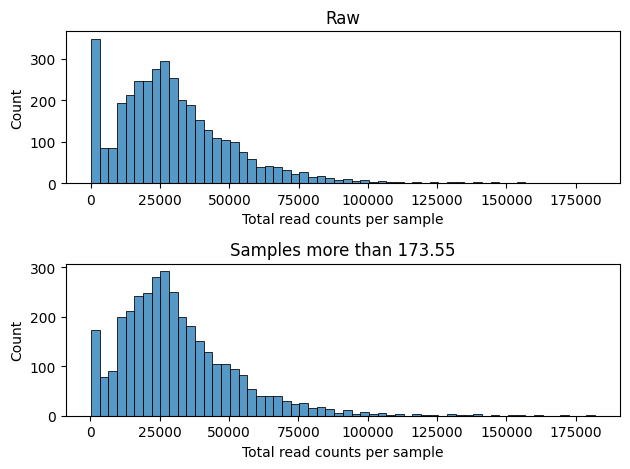

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt 


# threshold = 10000
threshold = 173.55

plt.subplot(2, 1, 1)
sns.histplot(data= total_reads)
# plt.xlim(0, 10000)
plt.xlabel("Total read counts per sample")
plt.title("Raw")

plt.subplot(2, 1, 2)
sns.histplot(data= total_reads[total_reads > threshold])
# plt.xlim(0, 10000)
plt.xlabel("Total read counts per sample")
plt.title(f"Samples more than {threshold}")

plt.tight_layout()

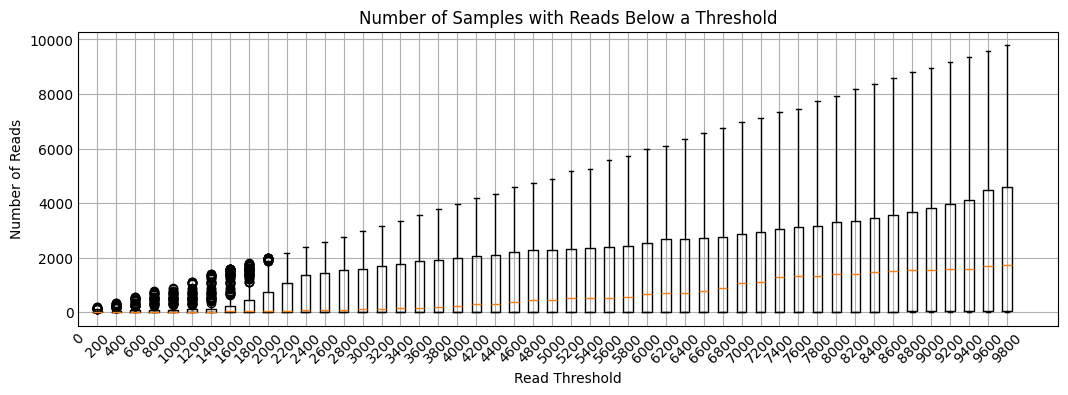

In [30]:
import matplotlib.pyplot as plt 


values = range(0, 10000, 200)
x = []
y = []
for value in values:
    # print(value, total_reads[total_reads < value].shape[0])
    x.append(value)
    y.append(total_reads[total_reads < value].values )


with plt.style.context("_mpl-gallery"):
    plt.figure(figsize=(10, 3))
    plt.boxplot(y, positions= x, widths= 100)
    plt.title('Number of Samples with Reads Below a Threshold')
    plt.xticks(rotation= 45)
    plt.xlabel('Read Threshold')
    plt.ylabel('Number of Reads')

In [ ]:
echo "normalize zotu table ..."
usearch11 \
    -otutab_rare ./results/feature_table/zotutab_raw.txt \
    -sample_size 20000 \
    -randseed 123 \
    -output ./results/feature_table/zotutab_20k.txt \
    # -threads 60
echo "Done"


In [6]:
%%bash
# Normalize to 5k reads / sample
echo "normalize zotu table ..."
usearch11 \
    -otutab_rare ./results/feature_table/zotutab_raw.txt \
    -sample_size 10000 \
    -randseed 123 \
    -output ./results/feature_table/zotutab_10k.txt \
    # -threads 60
echo "Done"

normalize zotu table ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



02:03 3.8Gb   100.0% Reading ./results/feature_table/zotutab_raw.txt.txtature_table/zotutab_raw.txtture_table/zotutab_raw.txtable/zotutab_raw.txteature_table/zotutab_raw.txt/zotutab_raw.txture_table/zotutab_raw.txtresults/feature_table/zotutab_raw.txtutab_raw.txtresults/feature_table/zotutab_raw.txtesults/feature_table/zotutab_raw.txtults/feature_table/zotutab_raw.txt./results/feature_table/zotutab_raw.txt ./results/feature_table/zotutab_raw.txtsults/feature_table/zotutab_raw.txts/feature_table/zotutab_raw.txt/results/feature_table/zotutab_raw.txtresults/feature_table/zotutab_raw.txts/feature_table/zotutab_raw.txts/feature_table/zotutab_raw.txtg ./results/feature_table/zotutab_raw.txtature_table/zotutab_raw.txttable/zotutab_raw.txt/feature_table/zotutab_raw.txt_table/zotutab_raw.txtle/zotutab_raw.txte_table/zotutab_raw.txt/feature_table/zotutab_raw.txte_table/zotutab_raw.txtble/zotutab_raw.txture_table/zotutab_raw.txt.txtture_table/zotutab_raw.txtfeature_table/zotutab_raw.txt/feature_t

Done


In [53]:
rared_zotu_table = pd.read_table("./results/feature_table/zotutab_6k.txt")

In [54]:
rared_zotu_table.head(5)

,#OTU ID,F146a,F146b,F146c,F146d,F146e,F147a,F147b,F147c,F147d,...,G99a,G99b,G99c,G99d,G99e,G9a,G9b,G9c,G9d,G9e
0,Zotu34128,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Zotu3,39,31,32,33,46,2,2,3,4,...,0,0,0,0,0,1,1,0,0,0
2,Zotu155,4,5,1,4,4,1,4,3,6,...,0,0,0,0,0,4,1,4,1,0
3,Zotu70143,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Zotu178,20,10,18,15,13,18,13,21,16,...,2,3,1,2,2,0,0,0,0,0


In [72]:
# Some samples have been removed.
zotu_table.columns.__len__()-1, rared_zotu_table.columns.__len__()-1

(3660, 3233)

In [71]:
# Meanwhile, some zOTUs have been removed.
zotu_table.index.__len__(), rared_zotu_table.index.__len__()

(165993, 165645)

## 6.10. <a id='toc6_10_'></a>[Diversity](#toc0_)

- 如何解释多样性指标？ 

[https://drive5.com/usearch/manual/diversity_metrics_meaning.html](https://drive5.com/usearch/manual/diversity_metrics_meaning.html)

**Diversity metrics cannot be meaningfully measured by amplicon sequencing**

The above considerations show that it is impossible to measure meaningful values for any diversity metric using NGS amplicon sequencing. However, it is still possible to compare alpha diversity between groups.

- 如何选择多样性指标？

<span style="color:red">**Alpha多样性（Alpha Diversity）**</span>：在扩增子测序中，**存在/缺失（Presence/absence）分析尤其不可靠**，因此应尽量避免使用基于存在/缺失的指标（如物种丰富度Richness、未加权UniFrac）。低丰度OTU的计数比高丰度OTU更不可信，因为它们可能完全由样本间交叉污染（cross-talk）或虚假OTU导致。因此，**通常建议使用对低频OTU权重较低的指标**，例如：**Shannon熵**（Shannon entropy）和 **Simpson指数**（Simpson index）。但需注意：（1）**Simpson指数**可能受单一高丰度OTU主导，而该OTU的高丰度可能是由于偏差（如该物种的16S基因拷贝数较高，而其他物种仅1-2个拷贝）；（2）反之，若样本中**无高丰度OTU**，也可能是技术假象（如某个优势物种因引物错配被PCR强烈抑制）。  

**推荐做法**：（1）使用**Shannon熵**作为Alpha多样性变化的总体指标，但需注意其差异可能源于OTU数量的变化、频率分布形态的变化或两者共同作用；（2）通过**可视化各组频率分布**（如usearch v11将支持的新功能）能更好地理解差异。  

---

<span style="color:red">**Beta多样性（Beta Diversity）**</span>：UniFrac的设计者认为，**基于系统发育树的方法（tree-based）** 能更合理地比较样本，因为序列相似度高的OTU往往占据相似的生态位。但这一假设在微生物学中的有效性尚不明确（如有相关证据请告知）。  

- **对于QIIME生成的OTU（通常噪声较大）**，使用UniFrac是必要的，可抑制噪声导致的假差异。  
- **但对于UPARSE或UNOISE生成的高精度OTU**，UniFrac通常是**较差的Beta多样性指标**，因为它对高相似度OTU之间的差异极不敏感，而这些差异很可能具有重要生物学意义（即使OTU生态位相似）。  

**推荐做法**：  
- **默认使用加权Jaccard（weighted Jaccard）**，除非有明确理由选择其他方法。  

---

**关键总结**  
| **分析类型**   | **推荐指标**                | **原因**                                                                 |
|--------------|---------------------------|-------------------------------------------------------------------------|
| **Alpha多样性** | Shannon熵                | 平衡敏感性和稳健性，减少低丰度OTU的干扰                                  |
| **Beta多样性** | 加权Jaccard（高精度OTU时） | 避免UniFrac对高相似度OTU差异的忽略，更反映真实生物变异                   |

> **注**：分析方法需根据数据质量（如是否去噪）和研究目标灵活调整，可视化验证至关重要。

### 6.10.1. <a id='toc6_10_1_'></a>[alpha diversity](#toc0_)

The **-metrics** option specifies one or more metric names separated by **commas**. Default is a few popular metrics. Popular does not necessarily mean recommended. 

🧬 Diversity Metrics 

| Name        | Units | Description                                                                                                                                                       |
| ----------- | ----- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| richness    | OTUs  | Number of OTUs with at least one read for the sample.                                                                                                             |
| mirror      | OTUs  | See mirror estimator.                                                                                                                                             |
| FE          | OTUs  | See singleton-free estimator.                                                                                                                                     |
| chao1       | OTUs  | Chao-1 estimator, calculated as N + S² / (2D) where N is the number of OTUs, S is the number of singleton OTUs and D is the number of doublet OTUs (abundance 2). |
| shannon\_2  | bits  | Shannon index (log base 2).                                                                                                                                       |
| shannon\_e  | nats  | Shannon index (log base e).                                                                                                                                       |
| shannon\_10 | dits  | Shannon index (log base 10).                                                                                                                                      |
| jost        | OTUs  | Jost index of order *q* (default 1.5, configurable via `-jostq`).                                                                                                 |
| jost1       | OTUs  | Jost index of order 1, the effective number of species given by the Shannon index.                                                                                |

⚖️ Evenness Metrics

| Name           | Units       | Description                                                                                   |
| -------------- | ----------- | --------------------------------------------------------------------------------------------- |
| simpson        | Probability | Simpson index: sum of squared OTU frequencies. High values (\~1) imply dominance by few OTUs. |
| dominance      | Probability | 1 - Simpson index. Probability that two randomly selected reads are from different OTUs.      |
| equitability   | ?           | Pielou's evenness: Shannon index divided by log(number of OTUs). 1 = perfectly even.          |
| robbins        | Frequency   | Robbins index: S / (N + 1), where S = singleton OTUs, N = total OTUs.                         |
| berger\_parker | Frequency   | Berger-Parker index: frequency of the most abundant OTU. High value = dominance.              |

📦 Other

| Name  | Units | Description                           |
| ----- | ----- | ------------------------------------- |
| reads | Reads | Total number of reads for the sample. |


In [63]:
%%bash 
mkdir -p results/diversity/alpha
echo "create directory for diversity analysis"

create directory for diversity analysis


原始的：

In [2]:
%%bash 
echo "alpha metrics per samples ..."
usearch11 \
    -alpha_div results/feature_table/zotutab_raw.txt \
    -output results/diversity/alpha/zotutab_raw_alpha.txt \
    # -threads 30
echo "Done"

alpha metrics per samples ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



02:04 3.8Gb   100.0% Reading results/feature_table/zotutab_raw.txtesults/feature_table/zotutab_raw.txtlts/feature_table/zotutab_raw.txtfeature_table/zotutab_raw.txt/feature_table/zotutab_raw.txt results/feature_table/zotutab_raw.txtults/feature_table/zotutab_raw.txtraw.txtts/feature_table/zotutab_raw.txttutab_raw.txtble/zotutab_raw.txtotutab_raw.txt_raw.txttab_raw.txttutab_raw.txtature_table/zotutab_raw.txtature_table/zotutab_raw.txt/zotutab_raw.txte/zotutab_raw.txtraw.txte/zotutab_raw.txtature_table/zotutab_raw.txtotutab_raw.txtle/zotutab_raw.txtraw.txtw.txtlts/feature_table/zotutab_raw.txttw.txt.txttutab_raw.txtw.txtzotutab_raw.txtw.txtxtw.txte_table/zotutab_raw.txtle/zotutab_raw.txteature_table/zotutab_raw.txtable/zotutab_raw.txttab_raw.txt.txtfeature_table/zotutab_raw.txt/zotutab_raw.txtable/zotutab_raw.txt_raw.txttable/zotutab_raw.txttable/zotutab_raw.txt_table/zotutab_raw.txtle/zotutab_raw.txtlts/feature_table/zotutab_raw.txtesults/feature_table/zotutab_raw.txtw.txtture_table/zot

Done


先看看5k：

In [1]:
%%bash 
echo "alpha metrics per samples ..."
usearch11 \
    -alpha_div results/feature_table/zotutab_5k.txt \
    -output results/diversity/alpha/zotutab_5k_alpha.txt \
    # -threads 30
echo "Done"

alpha metrics per samples ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



01:48 3.4Gb   100.0% Reading results/feature_table/zotutab_5k.txttutab_5k.txt_5k.txtable/zotutab_5k.txtt_table/zotutab_5k.txttotutab_5k.txtab_5k.txtable/zotutab_5k.txt/zotutab_5k.txt5k.txtutab_5k.txte/zotutab_5k.txte_table/zotutab_5k.txtre_table/zotutab_5k.txt.txt/zotutab_5k.txtab_5k.txtzotutab_5k.txt_table/zotutab_5k.txtture_table/zotutab_5k.txtble/zotutab_5k.txt/zotutab_5k.txtle/zotutab_5k.txt_5k.txtble/zotutab_5k.txtzotutab_5k.txttxtutab_5k.txts/feature_table/zotutab_5k.txtutab_5k.txt/zotutab_5k.txt_5k.txtab_5k.txt/zotutab_5k.txtk.txtab_5k.txtzotutab_5k.txture_table/zotutab_5k.txtxttk.txtutab_5k.txte/zotutab_5k.txtble/zotutab_5k.txtle/zotutab_5k.txtable/zotutab_5k.txt


Done


再来一个6K：

In [64]:
%%bash 
echo "alpha metrics per samples ..."
usearch11 \
    -alpha_div results/feature_table/zotutab_6k.txt \
    -output results/diversity/alpha/zotutab_6k_alpha.txt \
    # -threads 30
echo "Done"

alpha metrics per samples ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



01:48 3.3Gb   100.0% Reading results/feature_table/zotutab_6k.txttxtzotutab_6k.txtb_6k.txtxtk.txttxtxtature_table/zotutab_6k.txttxttutab_6k.txtre_table/zotutab_6k.txtble/zotutab_6k.txtutab_6k.txtb_6k.txttab_6k.txte/zotutab_6k.txtk.txttxtxte_table/zotutab_6k.txte/zotutab_6k.txttable/zotutab_6k.txtfeature_table/zotutab_6k.txtature_table/zotutab_6k.txte/zotutab_6k.txtotutab_6k.txtxture_table/zotutab_6k.txttab_6k.txt_6k.txt.txteature_table/zotutab_6k.txture_table/zotutab_6k.txt


Done


In [ ]:
%%bash 
echo "alpha metrics per samples ..."
usearch11 \
    -alpha_div results/feature_table/zotutab_20k.txt \
    -output results/diversity/alpha/zotutab_20k_alpha.txt \
    # -threads 30
echo "Done"


To calculate the statistical significance of a change in metric between groups, use the alpha_div_sig command. [https://www.drive5.com/usearch/manual/diversity_metrics_compare_groups.html](https://www.drive5.com/usearch/manual/diversity_metrics_compare_groups.html)

In [68]:
alphas = pd.read_table("results/diversity/alpha/zotutab_6k_alpha.txt")
alphas.shape

(3233, 23)

In [74]:
alphas.head(10)

,Sample,berger_parker,buzas_gibson,chao1,dominance,equitability,jost,jost1,reads,richness,...,shannon_e,shannon_2,shannon_10,flyvbjerg,mirror,mirrorns,logfit,logfitns,logfitmu,logfitmuns
0,F146a,0.0170,0.240,7050.4,0.998,0.921,870.9,1437.5,6000.0,2693.0,...,7.27,10.5,3.16,1711.8,3571.0,1188.0,2730.0,2620.0,-1.0,-0.3
1,F146b,0.0142,0.257,6561.2,0.998,0.928,1011.2,1544.2,6000.0,2724.0,...,7.34,10.6,3.19,2324.0,3642.0,1250.0,2717.0,2607.0,-1.0,-0.3
2,F146c,0.0175,0.247,7069.3,0.998,0.923,921.2,1479.8,6000.0,2726.0,...,7.30,10.5,3.17,1825.3,3602.0,1172.0,2783.0,2669.0,-1.0,-0.3
3,F146d,0.0120,0.273,7046.2,0.999,0.930,1061.3,1639.0,6000.0,2867.0,...,7.40,10.7,3.21,2335.7,3786.0,1205.0,2930.0,2812.0,-1.0,-0.3
4,F146e,0.0200,0.242,6713.7,0.998,0.920,865.7,1453.4,6000.0,2734.0,...,7.28,10.5,3.16,2444.4,3618.0,1185.0,2783.0,2669.0,-1.0,-0.3
5,F147a,0.0340,0.236,5793.3,0.998,0.920,791.7,1416.5,6000.0,2671.0,...,7.26,10.5,3.15,2506.9,3627.0,1262.0,2579.0,2579.0,-1.0,-1.0
6,F147b,0.0393,0.226,6385.9,0.997,0.914,717.1,1357.1,6000.0,2666.0,...,7.21,10.4,3.13,2256.9,3558.0,1198.0,2669.0,2560.0,-1.0,-0.3
7,F147c,0.0443,0.229,6894.8,0.997,0.913,678.0,1374.4,6000.0,2739.0,...,7.23,10.4,3.14,1892.1,3632.0,1184.0,2776.0,2664.0,-1.0,-0.3
8,F147d,0.0455,0.218,6065.1,0.996,0.910,638.9,1307.7,6000.0,2652.0,...,7.18,10.4,3.12,2209.9,3567.0,1206.0,2613.0,2613.0,-1.0,-1.0
9,F147e,0.0470,0.216,5992.8,0.996,0.910,634.8,1295.5,6000.0,2624.0,...,7.17,10.3,3.11,2133.0,3538.0,1210.0,2571.0,2571.0,-1.0,-1.0


meta format: [https://www.drive5.com/usearch/manual/metadata_file.html](https://www.drive5.com/usearch/manual/metadata_file.html)

```bash 
#1. Sample label.
#2. Category name.

Example

SampleA    Sick
SampleB    Sick
SampleC    Healthy
```

In [ ]:
# %%bash 
# echo "Different analysis between groups ..."
# usearch11 \
#     -alpha_div_sig results/feature_table/zotutab_raw.txt \
#     -meta results/diversity/alpha/metainfo.txt \
#     -tabbedout results/diversity/alpha/sigs.txt \
#     -threads 30
# echo "Done"

### 6.10.2. <a id='toc6_10_2_'></a>[beta diversity](#toc0_)

```bash
Example: calculate all supported beta metrics and write output in directory /results/beta

usearch -beta_div otutable.txt -filename_prefix /results/beta/
```

In [73]:
%%bash 
mkdir -p results/diversity/beta
echo "beta metrics per samples"

beta metrics per samples


In [ ]:
%%bash 
# Long time with only one thread.
echo "beta metrics per samples ..."
usearch11 \
    -beta_div results/feature_table/zotutab_raw.txt \
    -threads 30 \
    -filename_prefix results/diversity/beta/beta \
    # -output results/diversity/beta/beta.txt \
echo "Done"

In [ ]:
%%bash 
# Long time with one thread limitation.
echo "Beta metrics: jaccard,bray_curtis ..."
usearch11 \
    -beta_div results/feature_table/zotutab_6k.txt \
    -threads 30 \
    -metrics jaccard,bray_curtis
echo Done

In [ ]:
usearch11 \
-beta_div ../../../feature_table/zotutab_20k.txt \
-metrics jaccard,bray_curtis \
-threads 30


## 6.11. <a id='toc6_11_'></a>[稀释曲线](#toc0_)

### 6.11.1. <a id='toc6_11_1_'></a>[Octave plots for visualizing alpha diversity](#toc0_)

[https://www.drive5.com/usearch/manual/octave_plot.html](https://www.drive5.com/usearch/manual/octave_plot.html)

In [ ]:
# %%bash
# usearch -otutab_octave otutab.txt -distmxin distmx.txt \
#   -otutab_with_singles otutab_singles.txt \
#   -htmlout octave.html -svgout octave.svg

### 6.11.2. <a id='toc6_11_2_'></a>[Alpha diversity rarefaction curve](#toc0_)

[https://www.drive5.com/usearch/manual/cmd_alpha_div_rare.html](https://www.drive5.com/usearch/manual/cmd_alpha_div_rare.html)

In [75]:
%%bash 
echo "Rare curve ..."
mkdir results/diversity/rare_curve

Rare curve ...


In [77]:
%%bash 
echo "Alpha rarefaction ..."
usearch11 -alpha_div_rare results/feature_table/zotutab_raw.txt -output results/diversity/rare_curve/zotutab_raw_rare.txt -threads 60
echo Done

Alpha rarefaction ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license





usearch11 -alpha_div_rare results/feature_table/zotutab_raw.txt -output results/diversity/rare_curve/zotutab_raw_rare.txt -threads 60

---Fatal error---
alpha_div_rare not supported


Done


## 6.12. <a id='toc6_12_'></a>[物种注释](#toc0_)

**如何选择合适的数据库进行分类鉴定？** [https://drive5.com/usearch/manual/faq_tax_db.html](https://drive5.com/usearch/manual/faq_tax_db.html)

I recommend using a authoritatively classified sequences, e.g. for 16S the most recent RDP training set or LTP release. I believe it is **best to use a database of type strain and isolate sequences** rather than Greengenes, SILVA or RDP, because these databases have high error rates -- roughly one in five of the taxonomy annotations are wrong [https://drive5.com/usearch/manual/sintax_algo.html](https://drive5.com/usearch/manual/sintax_algo.html).

### 6.12.1. <a id='toc6_12_1_'></a>[Algorithm](#toc0_)

- The nbc_tax command is an implementation of the RDP **Naive Bayesian Classifier algorithm** (Wang et al. 2007).
  - [https://www.drive5.com/usearch/manual/cmd_nbc_tax.html](https://www.drive5.com/usearch/manual/cmd_nbc_tax.html)

In [ ]:
# %%bash 
# usearch11 \
#     -nbc_tax ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
#     -db ref16s.fa \
#     -strand plus \
#     -tabbedout tax.txt

- 使用 **sintax** 对ASV/OTU序列进行分类注释。需准备带有标注的参考数据库（如 SILVA、Greengenes 等，需先用 makeudb_sintax 构建 .udb 格式）。下面以 SILVA 数据库为例：

In [ ]:
%%bash 
# Long time ...
echo "Aannotation with sintax ..."
usearch11 \
    -sintax ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu.fasta \
    -db ./dbs/silva_16s_v123_usearch.udb \
    -tabbedout ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_otu_sintax.txt \
    -strand both \
    -sintax_cutoff 0.8 \
    -threads 62

In [ ]:
%%bash 
# Long time ...
echo "Aannotation with sintax ..."
usearch11 \
    -sintax ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu.fasta \
    -db ./dbs/silva_16s_v123_usearch.udb \
    -tabbedout ./results/merge_read_all_samples/all_samples_filtered_dereplicated_nonchimeras_zotu_sintax.txt \
    -strand both \
    -sintax_cutoff 0.8 \
    -threads 60

### 6.12.2. <a id='toc6_12_2_'></a>[Rank annotation](#toc0_)

In [ ]:
# %%bash 
# usearch11 \
#     -sintax_summary sintax.txt \
#     -otutabin otutab.txt \
#     -output phylum_summary.txt \
#     -rank p

# 7. <a id='toc7_'></a>[附录](#toc0_)

## 7.1. <a id='toc7_1_'></a>[格式化数据库](#toc0_)

Search commands require a -db option specifying a database filename. For u-commands (usearch_global, usearch_local and ublast) the database may be in FASTA format or UDB format. Other search commands (search_local and search_global) support FASTA only. The file format is automatically detected, so the -db option is used for both file types.

**Indexed databases**

The u-commands are designed to optimize search speed for large datasets. A key technique is using an index on the database that supports rapid retrieval of word counts or seeds. The index can be built in memory on the fly from a FASTA file, or can be pre-built and stored in a UDB file. Using FASTA can be convenient, but with large database load times are longer and more memory is required compared to using a UDB file. The memory required to store a UDB file in memory is approximately the same as the UDB file size. When indexes are created on the fly from a FASTA file, indexing options can be specified on the search command line. This also applies when a centroid database is constructed on the fly during clustering.

**Non-indexed databases**

The search_local and search_global commands do not use an index. They use a FASTA database file which is loaded into memory without creating an index. The memory required is approximately the same as the FASTA file size. Using these commands saves memory and can be convenient for small datasets, but searches are usually slower.

| Command          | DB format       | Indexed? | Time   | File size and RAM use                     |
|------------------|-----------------|----------|--------|-------------------------------------------|
| usearch_global   | FASTA or UDB    | Yes      | Faster | Larger (typically 2-3x FASTA file size)   |
| usearch_local    | FASTA or UDB    | Yes      | Faster | Larger (typically 2-3x FASTA file size)   |
| ublast           | FASTA or UDB    | Yes      | Faster | Larger (typically 2-3x FASTA file size)   |
| search_global    | FASTA           | No       | Slower | Smaller (similar to FASTA file size)      |
| search_local     | FASTA           | No       | Slower | Smaller (similar to FASTA file size)      |

三种数据库格式的比较：

| 命令               | 主要用途                     | 适用算法       | 索引结构                          | 典型应用场景                     |
|--------------------|----------------------------|---------------|-----------------------------------|--------------------------------|
| `makeudb_usearch`  | 通用序列相似性搜索           | USEARCH算法   | 基于k-mer的快速全局比对索引        | OTU聚类、全序列比对 |
| `makeudb_ublast`   | 高灵敏度蛋白/核苷酸搜索      | UBLAST算法    | 种子-扩展索引（类似BLAST）         | 远缘同源检测、功能基因注释 |
| `makeudb_sintax`   | 分类学快速注释               | SINTAX算法    | 精简k-mer索引（优化分类特征）      | 16S/ITS物种分类     |

构建UDB数据库：

```bash 
# USEARCH索引（聚类用）
usearch -makeudb_usearch ref.fasta -output ref_usearch.udb

# UBLAST索引（同源搜索用）
usearch -makeudb_ublast ref.fasta -output ref_ublast.udb -pattern 10111011

# SINTAX索引（分类用）
usearch -makeudb_sintax ref.fasta -output ref_sintax.udb -taxconfsout tax_confidence.txt
```

实际应用场景:

```bash 
# 场景1：OTU聚类（USEARCH索引）
usearch -cluster_otus reads.fq -otus otus.fa -udb ref_usearch.udb

# 场景2：蛋白域检测（UBLAST索引）
usearch -ublast query.faa -db ref_ublast.udb -evalue 1e-5 -accel 0.8

# 场景3：16S分类（SINTAX索引）
usearch -sintax reads.fq -db ref_sintax.udb -tabbedout taxonomy.txt
```

>**注意：同一序列文件经不同命令生成的UDB不可混用（如不能用SINTAX的UDB做UBLAST搜索）。**
---

### 7.1.1. <a id='toc7_1_1_'></a>[SINTAX downloads](#toc0_)

[https://drive5.com/usearch/manual/sintax_downloads.html](https://drive5.com/usearch/manual/sintax_downloads.html)

- 16S
   - [rdp_16s_v18.fa.gz](https://drive5.com/sintax/rdp_16s_v18.fa.gz) RDP training set v18 (21k seqs.). RDP license terms.
   - [rdp_16s_v16.fa.gz](https://drive5.com/sintax/rdp_16s_v16.fa.gz) RDP training set v16 (13k seqs.). RDP license terms.
   - [rdp_16s_v16_sp.fa.gz](https://drive5.com/sintax/rdp_16s_v16_sp.fa.gz) RDP training set with species names  (**not recommended**) (can species be predicted?).
   - [gg_16s_13.5.fa.gz](https://drive5.com/sintax/gg_16s_13.5.fa.gz) Greengenes v13.5 (1.2M seqs.). Greengenes license terms. (**not recommended**)
   - [silva_16s_v123.fa.gz](https://drive5.com/sintax/silva_16s_v123.fa.gz) SILVA v123 (1.6M seqs.). SILVA license terms. (**not recommended**)
   - [ltp_16s_v123.fa.gz](https://drive5.com/sintax/ltp_16s_v123.fa.gz) SILVA v123 LTP named isolate subset (12k seqs.) .SILVA license terms
 
- ITS
   - [UNITE (current "utax" version at unite.ut.ee)](https://unite.ut.ee/repository.php) (53k sequences in v7.1). UNITE license terms.
   - [rdp_its_v2.fa.gz](https://drive5.com/sintax/rdp_its_v2.fa.gz) RDP Warcup training set v2 (18k sequences). RDP license terms.
 
- 18S
    - [silva_18s_v123.fa.gz](https://drive5.com/sintax/silva_18s_v123.fa.gz) SILVA v123 eukaryotic 18S subset (140k seqs.) . [SILVA license terms](https://www.arb-silva.de/silva-license-information/)

例如：
>wget https://www.arb-silva.de/fileadmin/silva_databases/release_138_2/Exports/SILVA_138.2_SSURef_NR99_tax_silva.fasta.gz

### 7.1.2. <a id='toc7_1_2_'></a>[makeudb_sintax](#toc0_)

[https://drive5.com/usearch/manual/cmd_makeudb_sintax.html](https://drive5.com/usearch/manual/cmd_makeudb_sintax.html)

The makeudb_tax command creates a UDB database file from sequences in a FASTA file. The database file is compatible with the sintax, usearch_global and usearch_local commands. Using a udb index make the database faster to load, but otherwise does not change the results.

See SINTAX reference data downloads page for available reference files.

You don't need to trim sequences to the same region as your reads / OTUs.

The sequence labels in the FASTA file must contain taxonomy annotations.

Example
```bash
usearch -makeudb_sintax rdp_16s.fa -output rdp_16s.udb
```

In [ ]:
%%bash
echo "make dbs ..."
usearch11 \
    -makeudb_sintax ./dbs/silva_16s_v123.fa \
    -output ./dbs/silva_16s_v123_sintax.udb \
    -threads 62
echo Done

### 7.1.3. <a id='toc7_1_3_'></a>[makeudb_usearch](#toc0_)

[https://drive5.com/usearch/manual/cmd_makeudb_usearch.html](https://drive5.com/usearch/manual/cmd_makeudb_usearch.html)

The makeudb_usearch command creates a UDB database file from sequences in a FASTA file. Index parameters are set to defaults for usearch_global and usearch_local. These defaults can be overridden by specifying index parameters on the command line.

The name of the UDB file is specified by the -output option.

Example
```bash
usearch -makeudb_usearch db.fasta -output db.udb

usearch -makeudb_usearch db.fasta -output db.udb -wordlength 12 -dbstep 4
```

In [ ]:
%%bash
echo "make dbs ..."
usearch11 \
    -makeudb_usearch ./dbs/silva_16s_v123.fa \
    -output ./dbs/silva_16s_v123_usearch.udb \
    -threads 62
echo Done

### 7.1.4. <a id='toc7_1_4_'></a>[makeudb_ublast](#toc0_)

[https://drive5.com/usearch/manual/cmd_makeudb_ublast.html](https://drive5.com/usearch/manual/cmd_makeudb_ublast.html)

The makeudb_ublast command creates a UDB database file from sequences in a FASTA file. Index parameters are set to defaults for ublast. These defaults can be overridden by specifying index parameters on the command line.
Examples
```bash
usearch -makeudb_ublast db.fasta -output db.udb
```

In [ ]:
%%bash 
usearch11 \
    -makeudb_ublast ./dbs/silva_16s_v123.fa \
    -output ./dbs/silva_16s_v123_ublast.udb \
    -threads 62

### 7.1.5. <a id='toc7_1_5_'></a>[Check the information of dbs](#toc0_)

In [ ]:
%%bash 
echo "check the informations of dbs ..."
usearch11 \
    -udbinfo ./dbs/silva_16s_v123_usearch.udb
echo Done

check the informations of dbs ...
usearch v11.0.667_i86linux64, 1057Gb RAM, 64 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

From 2024 donated to public domain under CC0-1.0 license



           Seqs  1636081 (1.6M)
         Hashed  0
     SeqIx bits  32
    SeqPos bits  0
          Alpha  nt (4)
        Pattern  ""
     Word width  8
          Slots  0
      Dict size  65536 (65.5k)
         DBStep  1
     StepPrefix  ""
        DBAccel  100%
       EOR byte  N
       Tax data  N


### 7.1.6. <a id='toc7_1_6_'></a>[udb2fasta](#toc0_)

[https://drive5.com/usearch/manual/cmd_udb2fasta.html](https://drive5.com/usearch/manual/cmd_udb2fasta.html)

Extract sequences from a UDB file in FASTA format. Sequences are masked according to the settings used to created the UDB file.
Example
```bash
usearch -udb2fasta db.udb -output db.fasta
```

# 8. <a id='toc8_'></a>[Convert to html](#toc0_)

In [78]:
%%bash 
jupyter nbconvert --to html --output-dir docs pipeline_v1.1.0_usearch.ipynb 

[NbConvertApp] Converting notebook pipeline_v1.1.0_usearch.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 614707 bytes to docs/pipeline_v1.1.0_usearch.html
